# 📕 01 - Perspective Transformation with `cv2.getPerspectiveTransform`

This Jupyter Notebook demonstrates the concept and application of perspective transformation using OpenCV, a powerful tool in image processing. Perspective transformation is a crucial technique for altering the viewpoint from which an image is observed. This capability is incredibly useful across various domains, including image rectification, augmented reality, and analyzing visual data from unique perspectives, such as aircraft takeoffs.

## Understanding Perspective Transformation

Perspective transformation, in essence, enables us to modify the viewpoint of an image as if observing it from a different angle or position. This is particularly advantageous when we need to rectify images to a common perspective or when creating augmented reality applications that merge virtual and real-world imagery seamlessly.

### The Mathematical Foundation

At the core of perspective transformation is the `cv2.getPerspectiveTransform` function from OpenCV. This function computes a transformation matrix that is key to changing the perspective of an image. The process entails identifying four points within the source image, which define the region of interest. The corresponding points in the target image are set to delineate a rectangle, thus simulating a "bird's-eye" or top-down view.

The transformation matrix $M$ is calculated to project the source points onto the target image, achieving the desired perspective change. This involves a projective transformation where coordinates from the source image $(x, y)$ are mapped to new coordinates in the destination image $(x', y')$, according to the transformation:

$$
\begin{align*} 
\begin{bmatrix} x' \\ y' \\ w' \end{bmatrix} = M \cdot \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
\end{align*}
$$

In this equation, $(x', y')$ represents the transformed coordinates in the target image, and $w'$ is a scaling factor that ensures the transformed coordinates are in the correct proportion. The transformation matrix $M$ is a $3 \times 3$ matrix derived from the correspondence of four point pairs between the source and the target images.

The computation and application of this matrix enable the effective simulation of different perspectives, facilitating a variety of image analysis and enhancement techniques.

## Image Comparison: Video Frame and Aerial View

The images displayed are used for comparison in preparation for perspective transformation tasks within this project. On the left, we have the first frame from a video of Santos Dummont Airport, located in Rio de Janeiro, which will be analyzed throughout this notebook. On the right is an aerial view of the same airport, sourced from Google Earth.

:::{.callout-note}
**Santos Dummont Airport** Positioned in Rio de Janeiro, is one of the city's major airports. The first frame of the video captures a typical scene with aircraft positioned for takeoff, showcasing the airport's operational environment. The aerial view provides a comprehensive layout, including runways, taxiways, and parking areas, which are essential for our perspective transformation analysis..
:::

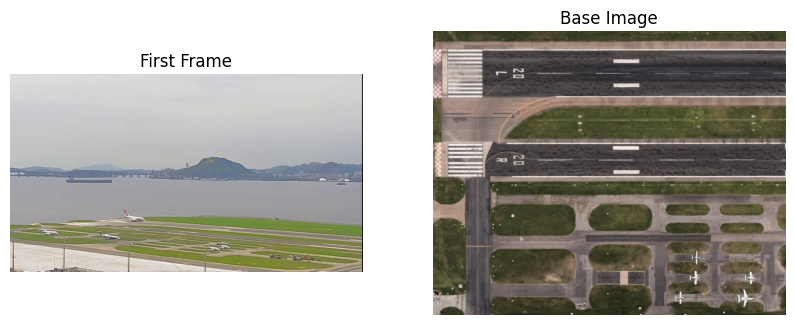

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from src.path import BASE_PATH

# Path to the base image and the first video frame
base_image_path = str(BASE_PATH / "images" / "base_image_santos_dummont_airport.png")
first_frame_path = str(BASE_PATH / "images" / "first_frame_santos_dummont_airport.png")

# Load the base image and the first frame
base_image = cv2.imread(base_image_path)
first_frame = cv2.imread(first_frame_path)

# Convert from BGR to RGB
base_image_rgb = base_image[..., ::-1]
first_frame_rgb = first_frame[..., ::-1]

# Configure the layout to display the images side by side
plt.figure(figsize=(10, 5))  # Adjust the figure size

# Plot the first frame on the left
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.imshow(first_frame_rgb)
plt.title("First Frame")
plt.axis("off")  # Remove the axes

# Plot the base image on the right
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.imshow(base_image_rgb)
plt.title("Base Image")
plt.axis("off")  # Remove the axes

plt.show()

By comparing these two images, we establish a visual understanding of the airport's layout from different perspectives. The video frame presents a view as seen from the ground, while the aerial image offers a top-down view, which is commonly used for detailed analysis and mapping applications.

## Visualization of Region of Interest on Footage

The coordinates for the source polygon, representing the region of interest in the footage, were obtained using the [Polygon Tool from Roboflow](https://roboflow.github.io/polygonzone/). This tool allows for precise selection and determination of points on an image.

Additionally, the target width and height values required for the perspective transformation were sourced from measurements taken in Google Earth. These dimensions correspond to the actual size of the area on the ground, providing a realistic scale for the transformed image.


In [11]:
# Set the initial SOURCE and TARGET values
SOURCE = np.array([[642, 784], [1960, 881], [1146, 1009], [-161, 852]])

TARGET_WIDTH = 310
TARGET_HEIGHT = 260

The `draw_lines_on_image` function is then used to overlay these points onto the first frame of the footage, connecting them with lines. This visual representation helps confirm the correct placement of the polygon on the image.

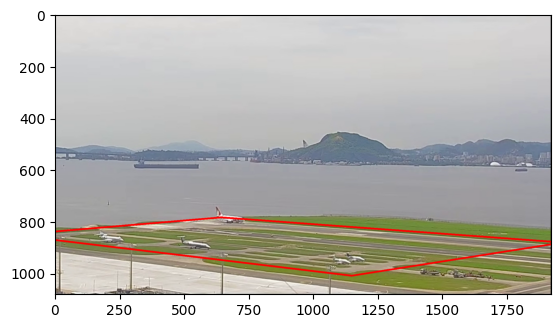

In [20]:
def draw_lines_on_image(image: np.ndarray, source_points: np.ndarray) -> np.ndarray:
    """
    Draw lines on the image given a set of points.

    Args:
        image (np.ndarray): The input image.
        source_points (np.ndarray): The points to draw lines.

    Returns:
        np.ndarray: The image with the lines drawn.
    """
    # Copy the image to avoid modifying the original
    lines_image = image.copy()

    # Draw the lines
    for i in range(len(source_points)):
        # Draw the line
        cv2.line(
            lines_image,
            tuple(source_points[i]),
            tuple(source_points[(i + 1) % len(source_points)]),
            (0, 0, 255),
            6,
        )

    return lines_image


image_with_lines = draw_lines_on_image(first_frame, SOURCE)
plt.imshow(image_with_lines[..., ::-1])

## Applying Perspective Transformation

The function `transform_perspective` applies a perspective transformation to the input image, utilizing the source coordinates obtained from the footage and the target projection dimensions derived from Google Earth.

## Process

1. The function takes the input image, source points, and target dimensions (width and height) as arguments.
2. It then calculates the target points, which form a rectangle with the specified target width and height. These points are the corners of the desired output image and define where the source points should map to in the transformed space.
3. Using OpenCV's `cv2.getPerspectiveTransform`, the function computes the transformation matrix from the source points to the target rectangle.
4. Finally, it applies this transformation matrix to the input image using `cv2.warpPerspective`, resulting in an image that has been transformed to a new perspective.


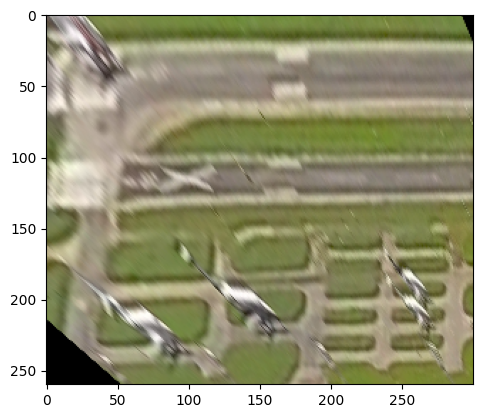

In [21]:
def transform_perspective(
    image: np.ndarray, source: np.ndarray, target_width: int, target_height: int
) -> np.ndarray:
    """
    Apply a perspective transformation to the input image.

    Args:
        image (np.ndarray): The input image.
        source (np.ndarray): The source points.
        target_width (int): The target width.
        target_height (int): The target height.

    Returns:
        np.ndarray: The transformed image.
    """
    # Define the target points
    target = np.array(
        [
            [0, 0],
            [target_width - 1, 0],
            [target_width - 1, target_height - 1],
            [0, target_height - 1],
        ]
    )

    # Calculate the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(
        source.astype(np.float32), target.astype(np.float32)
    )

    # Apply the perspective transformation
    transformed_image = image.copy()
    transformed_image = cv2.warpPerspective(
        transformed_image, matrix, (target_width, target_height)
    )

    return transformed_image


# use function transform_perspective to transform the first frame
transformed_image = transform_perspective(
    first_frame, SOURCE, TARGET_WIDTH, TARGET_HEIGHT
)
plt.imshow(transformed_image[..., ::-1])

The transformed image represents the bird's-eye view of the region of interest, with the source points adjusted to the dimensions provided, simulating the viewpoint from above, as if captured directly from the Google Earth measurements.

## Interactive Perspective Transformation with Streamlit

An interactive Streamlit application is provided to explore perspective transformation in real-time. The app enables the manipulation of source point coordinates and visualizes their impact on the perspective transformation. The purpose of this application is to facilitate an intuitive understanding of the following concepts:

- Perspective projection and how it relates to the source and target coordinates.
- The transformation matrix and its role in converting coordinates from one perspective to another.
- The effects of altering source coordinates on the transformed image, emphasizing the importance of precise point selection.

Aligning the runway with the x-axis simplifies the detection of any distortions that may arise from incorrect point placements. The real-time feedback provided by the Streamlit app assists in recognizing and correcting such distortions.

<center>
    <br>
    <img src = "https://github.com/carlosfab/aircraft-takeoff-speed-estimation/blob/main/images/demo-app-streamlit.png?raw=true" height=500>
    <br>
</center>

### Instructions to Run the Streamlit App

To run the Streamlit application, follow these below.

1. Activate the project environment:
   ```shell
   poetry shell
   ```

2. Change to the app directory

   ```bash
   cd src/streamlit
   ````

3. Run the Streamlit app:
   ```shell
   streamlit run app.py
   ```

Engage with the application, so you can gain hands-on experience with perspective transformation and better understand the practical implications of point selection on the final transformed image. The first frame image used for perspective transformation can be found within the project directory at the `aircraft-takeoff-speed-estimation/images/base_image_santos_dummont_airport.png`

